# Assignment 1  
Mohammad Rashiqul Alam  
malam25@illinois.edu  

### Load All Images to Notebook

In [1]:
# Modules
import os
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image


/home/rashiqul/workspace/ece549/picture/data


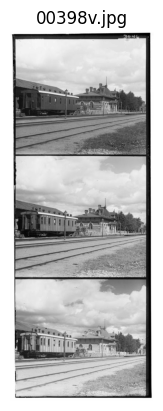

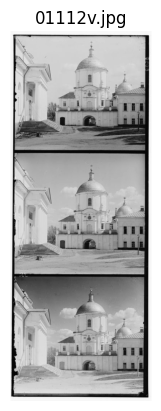

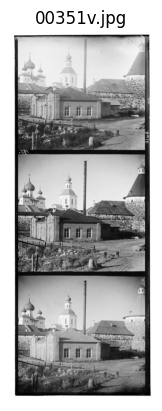

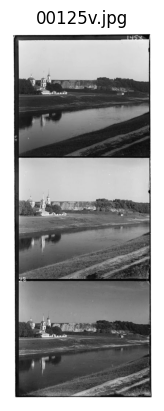

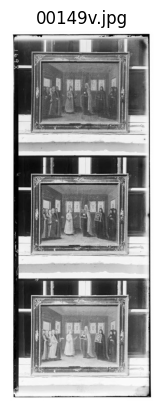

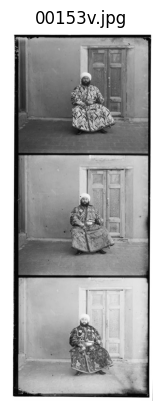

In [2]:
# Load images from directory
directory = os.path.join(os.path.dirname(os.getcwd()), "picture", "data")
print(directory)
image_files = [file for file in os.listdir(directory) if file.lower().endswith('.jpg')]

# Display aa 6 images
for file in image_files:
    path  = os.path.join(directory, file)
    image = Image.open(path)
    plt.imshow(image, cmap='gray')
    plt.title(file)
    plt.axis('off')
    plt.show()

### Image Cropping

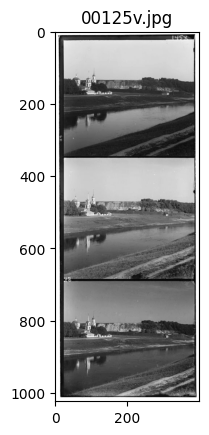

In [3]:
# Let's work with the first image in the list, but prefer '00153v.jpg' if present
preferred_image = "00125v.jpg"
if preferred_image in image_files:
    image_path = os.path.join(directory, preferred_image)
    selected_file = preferred_image
else:
    image_path = os.path.join(directory, image_files[0])
    selected_file = image_files[0]

image0 = Image.open(image_path)
plt.imshow(image0, cmap='gray')
plt.title(selected_file)
plt.show()

In [4]:
# Normalize the image to [0, 1] range and display it
image0 = np.array(image0) / 255.0

# Print the image dimension, size and the matrix
print(f"Image dimensions: {image0.shape}")
print(f"Image size: {image0.size}")
print(f"Image matrix:\n{image0}")

Image dimensions: (1024, 400)
Image size: 409600
Image matrix:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [5]:
# Calculate the height of the image
height = image0.shape[0]
# Calculate the height per channel
height_per_channel = int(height / 3)

# Print the height per channel
print(f"Height per channel: {height_per_channel}") 

Height per channel: 341


In [6]:
# Slice the image into its three color channels using the calculated height_per_channel
top_slice_channel     = image0[0 : height_per_channel, :]
middle_slice_channel  = image0[height_per_channel : 2 * height_per_channel, :]
bottom_slice_channel  = image0[2 * height_per_channel : 3 * height_per_channel, :]

Top Dimension: (341, 400)


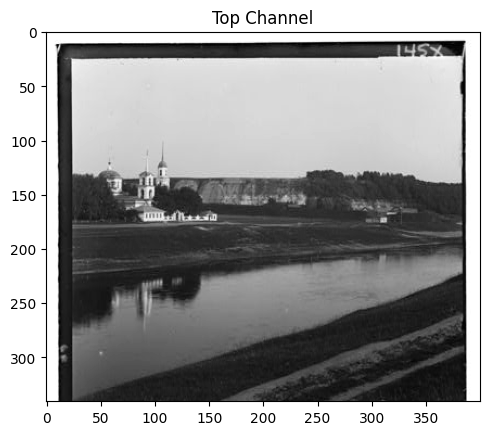

Middle Dimension: (341, 400)


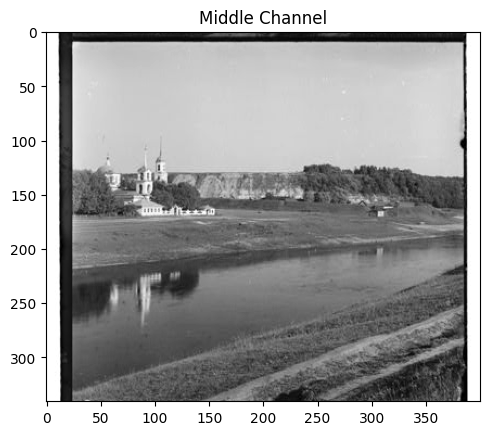

Bottom Dimension: (341, 400)


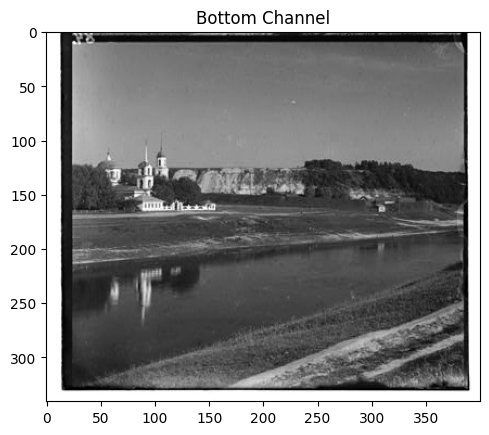

In [7]:
# Display the channels
for channel, slice in zip([top_slice_channel, middle_slice_channel, bottom_slice_channel], ['Top', 'Middle', 'Bottom']):
    plt.imshow(channel, cmap='gray')
    plt.title(f"{slice} Channel")
    print(f"{slice} Dimension: {channel.shape}")
    plt.show()

### Remove Borders

In [8]:
# Borders and clean-up
# There are black borders at the very top, bottom, left, and right of the image.
# These borders can be removed by slicing the image appropriately.
# Let's assume the borders are 8% wide on each side (taking a number in between 5-10%).

def remove_borders(channel, border_percent=0.08):
    """
    Function to remove borders from a given channel.
    """
    height, width = channel.shape
    # Get border sizes 
    top     = int(height * border_percent)
    bottom  = int(height * (1 - border_percent))
    left    = int(width * border_percent)
    right   = int(width * (1 - border_percent))
    # Crop the channel
    cropped = channel[top:bottom, left:right]
    
    return cropped


Top Dimension after border removal on white canvas: (286, 336)


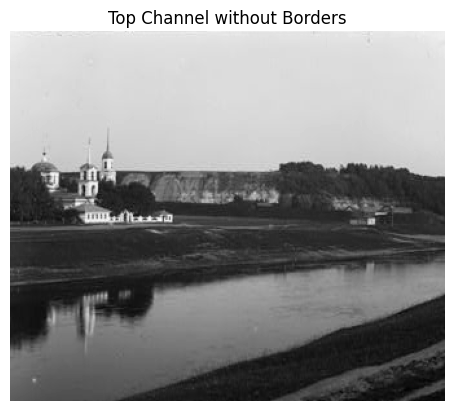

Middle Dimension after border removal on white canvas: (286, 336)


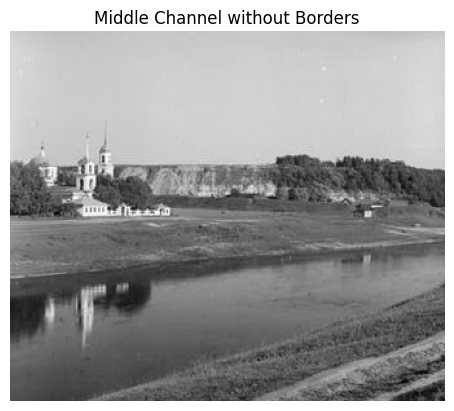

Bottom Dimension after border removal on white canvas: (286, 336)


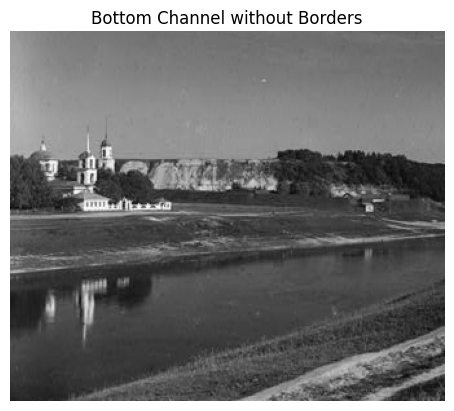

In [9]:
# Remove borders from each channel
top_slice_channel    = remove_borders(top_slice_channel)
middle_slice_channel = remove_borders(middle_slice_channel)
bottom_slice_channel = remove_borders(bottom_slice_channel)

# Display the channels after border removal
for channel, slice in zip([top_slice_channel, middle_slice_channel, bottom_slice_channel], ['Top', 'Middle', 'Bottom']):
    # Create a white canvas slightly larger than the cropped image
    h, w = channel.shape
    # Create a white canvas slightly larger than the cropped image
    padding = 50
    canvas_height = h + 2 * padding
    canvas_width  = w + 2 * padding
    # White canvas
    canvas = np.ones((canvas_height, canvas_width))  

    # Center the cropped image
    start_row = padding
    start_col = padding
    canvas[start_row : start_row + h, start_col : start_col + w] = channel
    
    # Display
    plt.imshow(channel, cmap='gray')
    plt.title(f"{slice} Channel without Borders")
    print(f"{slice} Dimension after border removal on white canvas: {channel.shape}")
    plt.axis('off')
    plt.show()

### Channel Alignment using SSD

In [10]:
# Assume the middle channel is the reference channel
reference_channel = middle_slice_channel

# Define a search window for alignment (e.g., 15 pixels in each direction)
search_window = 15

In [11]:
# Define a function to compute the Sum of Squared Differences (SSD)
def align_channel_ssd(reference, moving, search_window):
    """
    Align the moving channel to the reference channel using SSD within a search window.
    """
    h, w = reference.shape
    best_score = np.inf
    best_dx = 0
    best_dy = 0
    
    # Iterate over possible shifts within the search window
    for dy in range(-search_window, search_window + 1):
        for dx in range(-search_window, search_window + 1):
            # Find the overlap region
            # Rows
            ref_y0 = max(0, dy)
            ref_y1 = min(h, h + dy)
            mov_y0 = max(0, -dy)
            mov_y1 = min(h, h - dy)
            # Columns
            ref_x0 = max(0, dx)
            ref_x1 = min(w, w + dx)
            mov_x0 = max(0, -dx)
            mov_x1 = min(w, w - dx)

            # Only process if there's an overlap
            if ref_y1 > ref_y0 and ref_x1 > ref_x0:
                # Extract the overlapping regions
                ref_overlap  = reference[ref_y0 : ref_y1, ref_x0 : ref_x1]
                mov_overlap  = moving[mov_y0 : mov_y1, mov_x0 : mov_x1]

                # Compute SSD
                rp = ref_overlap - ref_overlap.mean()
                mp = mov_overlap - mov_overlap.mean()
                ssd = np.sum((rp - mp) ** 2)

                # Keep the best score and shift
                if ssd < best_score:
                    best_score = ssd
                    best_dx = dx 
                    best_dy = dx
    
    # Build align moving channel by applying best shift with zero padding and no warp-around
    algined_channel = np.zeros_like(moving)
    ref_y0 = max(0, best_dy)
    ref_y1 = min(h, h + best_dx)
    ref_x0 = max(0, best_dx)
    ref_x1 = min(w, w + best_dx)
    mov_y0 = max(0, -best_dy)
    mov_y1 = min(h, h - best_dy)
    mov_x0 = max(0, -best_dx)
    mov_x1 = min(w, w - best_dx)

    if ref_y1 > ref_y0 and ref_x1 > ref_x0:
        algined_channel[ref_y0 : ref_y1, ref_x0 : ref_x1] = moving[mov_y0 : mov_y1, mov_x0 : mov_x1]
    
    # Return both the shift (reporting requirement) and the aligned image
    return (best_dx, best_dy), algined_channel, best_score

### Print Image with Aligned Channel
Slide the top and bottom slice channel over the middle. Stack all the channels and print the image

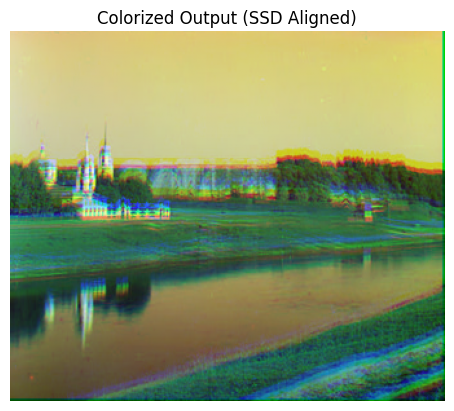

In [12]:
# Align the bottom channel to the middle (reference) channel
(shift, aligned_bottom, _) = align_channel_ssd(middle_slice_channel, bottom_slice_channel, search_window)

# Align the top channel to the middle (reference) channel
(shift, aligned_top, _) = align_channel_ssd(middle_slice_channel, top_slice_channel, search_window)

# Stack channels (assuming top=Blue, middle=Green, aligned_bottom=Red)
rgb_image = np.dstack([aligned_top, middle_slice_channel, aligned_bottom])
plt.imshow(rgb_image)
plt.title("Colorized Output (SSD Aligned)")
plt.axis('off')
plt.show()

### Channel Registration
Perform permutation using 6 possible options  
R, G, B  
R, B, G  
G, R, B  
G, B, R  
B, G, R  
B, R, G  

Permutation: {'Red': 'Top', 'Green': 'Middle', 'Blue': 'Bottom'}


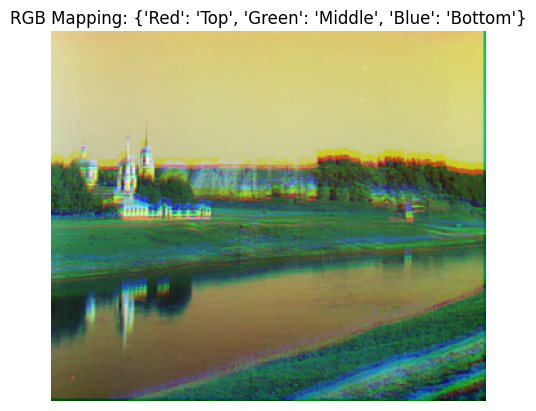

Permutation: {'Red': 'Top', 'Green': 'Bottom', 'Blue': 'Middle'}


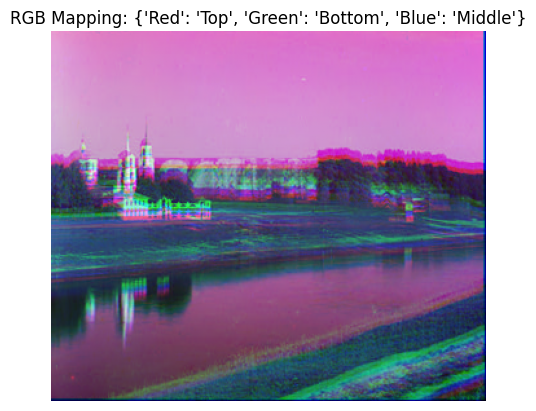

Permutation: {'Red': 'Middle', 'Green': 'Top', 'Blue': 'Bottom'}


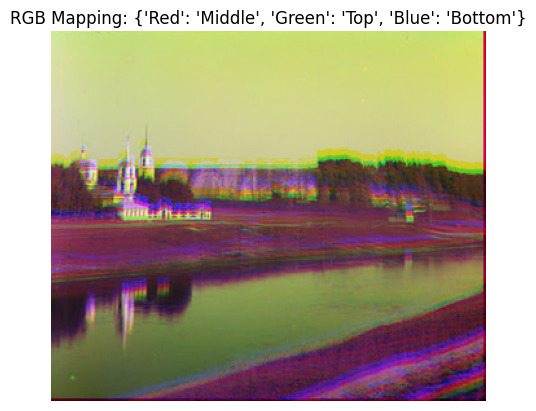

Permutation: {'Red': 'Middle', 'Green': 'Bottom', 'Blue': 'Top'}


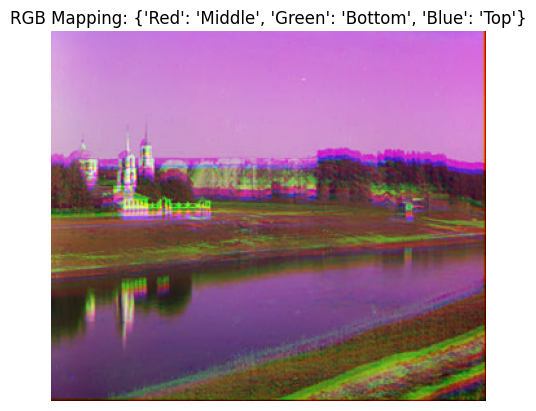

Permutation: {'Red': 'Bottom', 'Green': 'Top', 'Blue': 'Middle'}


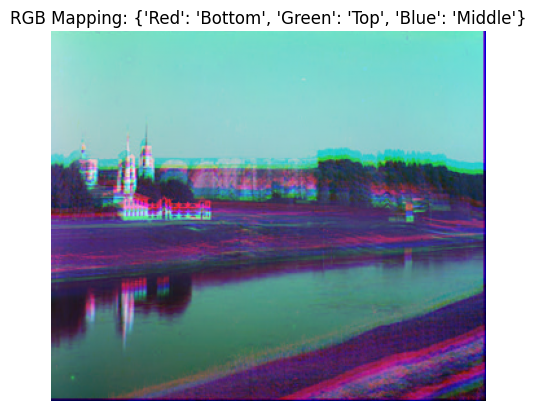

Permutation: {'Red': 'Bottom', 'Green': 'Middle', 'Blue': 'Top'}


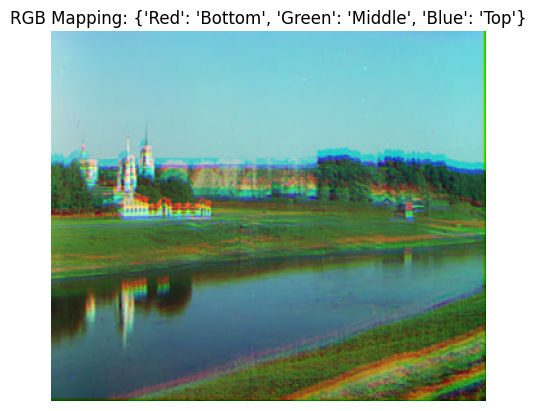

In [23]:
# Pefrorm alignment for all permutations of channel assignments
import itertools

# Channels to permute
channels = [aligned_top, middle_slice_channel, aligned_bottom]
labels = ['Top', 'Middle', 'Bottom']
# These colors are assumptions based on common conventions
colors = ['Red', 'Green', 'Blue']

# Display all permutations
for perm, label_perm in zip(itertools.permutations(channels), itertools.permutations(labels)):
    rgb_image = np.dstack(perm)
    mapping = {colors[i]: label_perm[i] for i in range(3)}
    print(f"Permutation: {mapping}")  # Shows which channel is assigned to R, G, B
    plt.imshow(rgb_image)
    plt.title(f"RGB Mapping: {mapping}")
    plt.axis('off')
    plt.show()

### Channel Alignment using NCC

In [14]:
def align_channel_ncc(reference, moving, search_window=15):
    """
    Align `moving` to `reference` using zero-mean normalized cross-correlation (NCC)
    over all integer shifts (dx, dy) with dx,dy in [-search_window, +search_window].
    Returns ((best_dx, best_dy), aligned_channel, best_ncc).
    """
    # Safe math
    ref = reference.astype(np.float32, copy=False)
    mov = moving.astype(np.float32, copy=False)
    h, w = ref.shape

    best_score = -np.inf
    best_dx = 0
    best_dy = 0

    # Exhaustive search
    for dy in range(-search_window, search_window + 1):
        for dx in range(-search_window, search_window + 1):
            # Overlap (intersection) rectangles for this shift
            ref_y0 = max(0,      dy); ref_y1 = min(h, h + dy)
            ref_x0 = max(0,      dx); ref_x1 = min(w, w + dx)
            mov_y0 = max(0,     -dy); mov_y1 = min(h, h - dy)
            mov_x0 = max(0,     -dx); mov_x1 = min(w, w - dx)

            if ref_y1 > ref_y0 and ref_x1 > ref_x0:
                # Overlapping regions (same shape)
                ref_overlap = ref[ref_y0:ref_y1, ref_x0:ref_x1]
                mov_overlap = mov[mov_y0:mov_y1, mov_x0:mov_x1]

                # ZNCC = dot( (R-meanR), (M-meanM) ) / (||...|| * ||...||)
                rp = ref_overlap - ref_overlap.mean()
                mp = mov_overlap - mov_overlap.mean()
                denom = np.sqrt((rp**2).sum() * (mp**2).sum())
                if denom > 0:
                    ncc = float((rp * mp).sum() / denom)
                    if ncc > best_score:
                        best_score = ncc
                        best_dx = dx
                        best_dy = dy

    # Build aligned moving with zero padding (no wrap)
    aligned_channel = np.zeros_like(mov)
    ref_y0 = max(0,      best_dy); ref_y1 = min(h, h + best_dy)   # <-- use best_dy
    ref_x0 = max(0,      best_dx); ref_x1 = min(w, w + best_dx)
    mov_y0 = max(0,     -best_dy); mov_y1 = min(h, h - best_dy)
    mov_x0 = max(0,     -best_dx); mov_x1 = min(w, w - best_dx)

    if ref_y1 > ref_y0 and ref_x1 > ref_x0:
        aligned_channel[ref_y0:ref_y1, ref_x0:ref_x1] = mov[mov_y0:mov_y1, mov_x0:mov_x1]

    return (best_dx, best_dy), aligned_channel, best_score


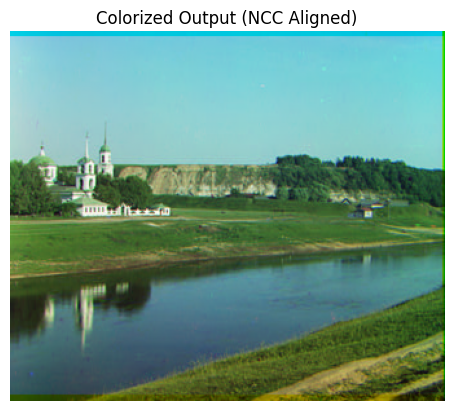

In [15]:
# Align the bottom channel to the middle (reference) channel using NCC
(bottom_shift, aligned_bottom_ncc, _) = align_channel_ncc(middle_slice_channel, bottom_slice_channel, search_window)

# Align the top channel to the middle (reference) channel using NCC
(top_shift, aligned_top_ncc, _) = align_channel_ncc(middle_slice_channel, top_slice_channel, search_window)

# Stack channels (assuming top=Blue, middle=Green, aligned_bottom=Red)
rgb_image_ncc = np.dstack([aligned_bottom_ncc, middle_slice_channel, aligned_top_ncc])
plt.imshow(rgb_image_ncc)
plt.title("Colorized Output (NCC Aligned)")
plt.axis('off')
plt.show()

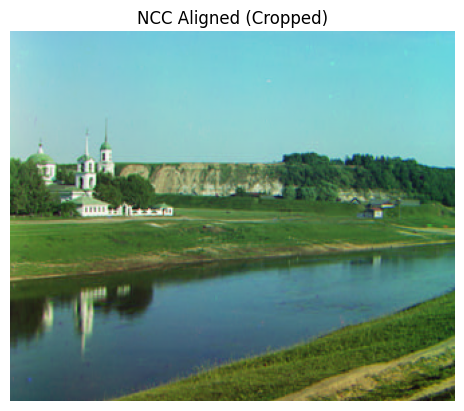

In [16]:
# Compute crop margins (based on max shifts used)
crop_x = max(abs(top_shift[0]), abs(bottom_shift[0]))
crop_y = max(abs(top_shift[1]), abs(bottom_shift[1]))

H, W, _ = rgb_image_ncc.shape
cropped_rgb_image_ncc = rgb_image_ncc[crop_y : H-crop_y, crop_x : W-crop_x, :]

plt.imshow(cropped_rgb_image_ncc)
plt.title("NCC Aligned (Cropped)")
plt.axis('off')
plt.show()
 

In [ ]:
def batch_process_images():
    """Process all images in image_files, align channels, print displacement vectors, display and save output as .jpeg in Gen/"""
    output_dir = os.path.join(os.path.dirname(os.getcwd()), "picture", "Gen")
    os.makedirs(output_dir, exist_ok=True)
    
    for file in image_files:
        print(f"\nProcessing: {file}")
        path = os.path.join(directory, file)
        image = Image.open(path)
        image_array = np.array(image) / 255.0
        
        # Crop into channels
        height = image_array.shape[0]

        height_per_channel = int(height / 3)

        top    = image_array[0 : height_per_channel, :]
        middle = image_array[height_per_channel : 2*height_per_channel, :]
        bottom = image_array[2*height_per_channel : 3*height_per_channel, :]

        # Print original channel size before cropping/alignment
        print(f"Original channel size (middle): {middle.shape[0]} x {middle.shape[1]}")
        
        # Remove borders
        top    = remove_borders(top)
        middle = remove_borders(middle)
        bottom = remove_borders(bottom)
        
        # Align channels using NCC
        (ncc_bottom_shift, aligned_bottom_ncc, _) = align_channel_ncc(middle, bottom, search_window)
        (ncc_top_shift, aligned_top_ncc, _) = align_channel_ncc(middle, top, search_window)
        print(f"{file}\tB {ncc_top_shift[1], ncc_top_shift[0]}\tR {ncc_bottom_shift[1], ncc_bottom_shift[0]}")
        
        # Stack channels (NCC result preferred for output)
        rgb_image = np.dstack([aligned_bottom_ncc, middle, aligned_top_ncc])
        
        # Crop margins based on max NCC shifts
        crop_x = max(abs(ncc_top_shift[0]), abs(ncc_bottom_shift[0]))
        crop_y = max(abs(ncc_top_shift[1]), abs(ncc_bottom_shift[1]))
        H, W, _ = rgb_image.shape
        cropped_rgb_image = rgb_image[crop_y:H-crop_y, crop_x:W-crop_x, :]

        # Print the size of the saved image
        print(f"Saved image size: {cropped_rgb_image.shape[0]} x {cropped_rgb_image.shape[1]}")

        # Display final image
        plt.imshow(cropped_rgb_image)
        plt.title(f"Final Colorized Output: {file}")
        plt.axis('off')
        plt.show()
        
        # Save as .jpeg in Gen/ with same filename
        save_path = os.path.join(output_dir, file)
        out_img = (cropped_rgb_image * 255).clip(0,255).astype(np.uint8)
        out_pil = Image.fromarray(out_img)
        out_pil.save(save_path, format='JPEG')
        print(f"Saved: {save_path}")




Processing: 00398v.jpg
Original channel size (middle): 341 x 397
NCC Displacement vectors: Top (-3, -5), Bottom (1, 6)


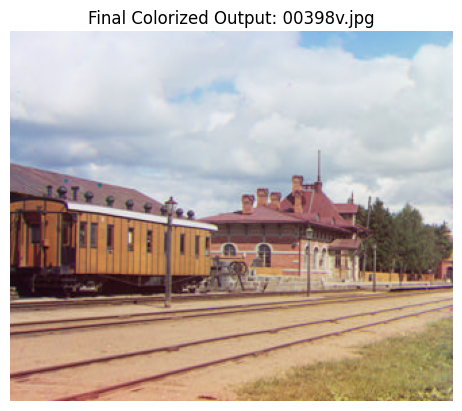

Saved image size: 274 x 328
Saved: /home/rashiqul/workspace/ece549/picture/Gen/00398v.jpg

Processing: 01112v.jpg
Original channel size (middle): 341 x 393
NCC Displacement vectors: Top (0, 0), Bottom (1, 5)


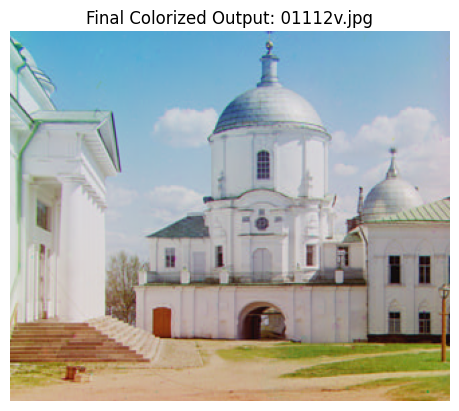

Saved image size: 276 x 328
Saved: /home/rashiqul/workspace/ece549/picture/Gen/01112v.jpg

Processing: 00351v.jpg
Original channel size (middle): 341 x 396
NCC Displacement vectors: Top (-1, -4), Bottom (1, 9)


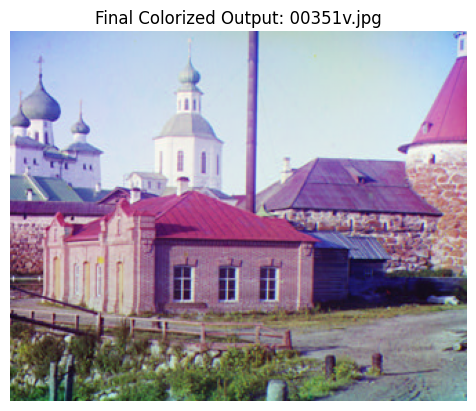

Saved image size: 268 x 331
Saved: /home/rashiqul/workspace/ece549/picture/Gen/00351v.jpg

Processing: 00125v.jpg
Original channel size (middle): 341 x 400
NCC Displacement vectors: Top (-2, -5), Bottom (-1, 4)


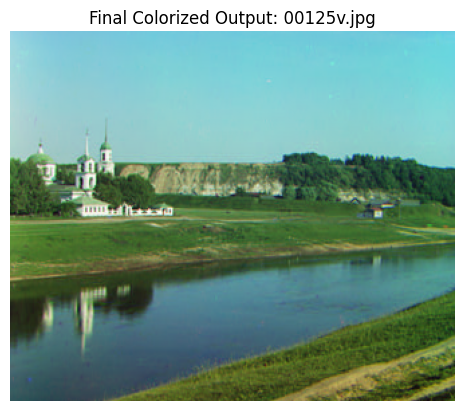

Saved image size: 276 x 332
Saved: /home/rashiqul/workspace/ece549/picture/Gen/00125v.jpg

Processing: 00149v.jpg
Original channel size (middle): 341 x 397
NCC Displacement vectors: Top (-2, -4), Bottom (0, 5)


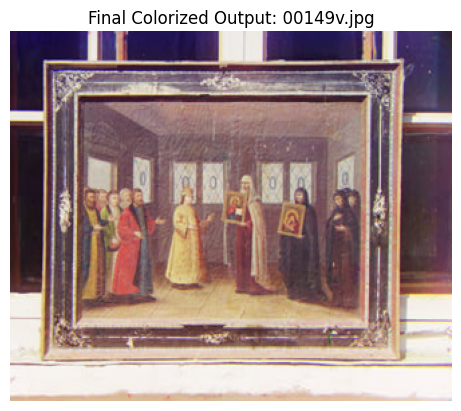

Saved image size: 276 x 330
Saved: /home/rashiqul/workspace/ece549/picture/Gen/00149v.jpg

Processing: 00153v.jpg
Original channel size (middle): 341 x 394
NCC Displacement vectors: Top (-3, -7), Bottom (2, 7)


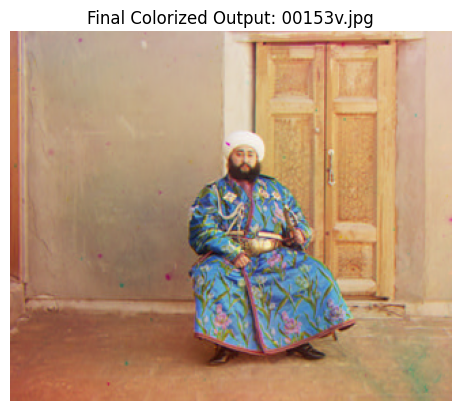

Saved image size: 272 x 325
Saved: /home/rashiqul/workspace/ece549/picture/Gen/00153v.jpg


In [22]:
# To run batch processing
batch_process_images()